# What are philosophers writing about anyways? 

One defintion of philosophy is the study of general and fundamental questions. Besides reading, analyzing, and studying enormous volumes of philosophical texts, is there another way (ideally faster) that we can unlock some of the topics discussed in philosophy? The goal of this notebook is to show a different way this question can be looked at using data.

The dataset we will be working with can be found on [Kaggle](https://www.kaggle.com/kouroshalizadeh/history-of-philosophy). This dataset contains pre-proccesed sentences from various schools of philosophy. The notebook will show initial summary visualizations of the dataset, and then will use topic modeling to extract insights into what philosophers write about.



### Version and Packages Required

This notebook was created using Python 3.6. In addition to common python packages, the following packages are required: 
* plotly
* pyLDAvis
* WordCloud

It is also important to note that to load the pretrained model file, you must have sklearn version==0.20.3 (the same version used to build the model). The code version of this notebook does include the code to build the model, so it is not required to load the model using python's pickle package. Please note, model training does take a significant amount of time ~1hour on the entire dataset. Since the topic model used is not guarenteed to converge to the optimal solution, and can identify a local optimum instead, a random seed was set in the model definition so the output should create the same model seen in this notebook. 




## 1) Load philosophy data - Introductory Analysis 

In [2]:
#Load csv data located in the data folder of the project 
import os
import sys
import pickle
import pandas as pd
import plotly.express as px
import numpy as np 

#Ensure philosophy_data.csv is stored in the data folder of the project 
fp = os.path.join("..", "data","philosophy_data.csv")
data_df = pd.read_csv(fp)


In [141]:
#Group by philosophy school and count number of sentences in each
count_schools = data_df.groupby("school", as_index = False)["author"].count().sort_values("author", ascending = False)

#Plot bar graph of sentence counts 
fig = px.bar(count_schools, x="school", y="author",title="Count of Sentences by School", labels={
                     "school": "School",
                     "author": "Total Sentence Count"
                 })
fig.update_traces(marker_color='cornflowerblue')
fig.show()

The above chart shows the total number of sentences in each philosophical school in descending order. We can see here a majority of the sentences come from the schools Analytic, Aristotle, German Idealism, and Plato. While the schools Stoicism, Nietzsche, Communisim, and Capitalism have the least amount of total sentences. 

Next lets look of the number of books/titles from each school that are contained in the dataset.

In [143]:
#Get number of books (titles) in each school
count_titles = data_df.groupby(["school", "title"], as_index = False).count().groupby("school", as_index=False)["title"].count().sort_values("title", ascending=False)

fig = px.bar(count_titles, x="school", y="title", title="Count of Titles by School", labels={
                     "school": "School",
                     "title": "Count of Titles"
                 })
fig.update_traces(marker_color='darkcyan')
fig.show()

An interesting thing to note is that while Aristotle and Plato have the lowest number of titles (one each), they both are in the top 4 schools when looking at total sentences in the dataset. It is interesting to see that a large portion of sentences in the dataset can be attributed to two philosophical schools, that consist of 1 book and one author. 

## 2) Topic Modeling - Can we identify common concepts in these texts?

The dataset contains various sentences from different philosophical texts from different authors and schools of thought. From this dataset of approximately 308 thousand sentences, can we determine what type of things authors wrote about? What about schools of philosophy that discuss similar topics? 

To look into these questions, we can fit a topic model over our dataset to discover themes in the text by identifying different topics discussed in these sentences. Topic modeling is an unsupervised method to cluster text data by trying to identify topics that occur in a collection of documents. In this case, each "document" is a sentence from a philosophical text in our dataset. This notebook generates an LDA (Latent Dirichlet Allocation) model to identify different topics discussed in philosophical texts. LDA assumes that each document is a mixture of different topics, and building a model over text data attempts to learn these topic distributions. From this, we can visualize overall concepts discuss across all schools of philosophy, and analyze what schools write about similar topics. For a more in depth introduction to LDA, you can visit this [website](https://medium.com/@pratikbarhate/latent-dirichlet-allocation-for-beginners-a-high-level-intuition-23f8a5cbad71).

The first step is to extract features from every document that will then be used to build the topic model. There are various ways to convert text data into numerical features, and in this notebook each sentence is converted into a sparse matrix that represents the word count of the words that appear in each sentence. The we will use sklearns implementation of LDA to create a topic model of the philosophy text data.

In [5]:
# Imports for Topic model 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction import text 

#Stop words from plato/aristotle text
stop_words_to_add = ["thou", "thy", "thee", "doth", "thyself"]
stop_words = text.ENGLISH_STOP_WORDS.union(stop_words_to_add)


In [6]:
#Train topic model using LDA - this takes a long time to train on the full dataset, skip to the next cell to load in trained model
#List of sentences to convert to features (matrix with just counts of words)
sent_list = list(data_df["sentence_spacy"])
num_words, num_topics = 20, 8

#Create count vectorizer object and transform sentences to word count matrix

count_vectorizer = CountVectorizer(stop_words=stop_words)
count_vec = count_vectorizer.fit_transform(sent_list)
    

In [ ]:
# Fit LDA model on count vector 
print("This may take a while to train on the full dataset...")
lda = LDA(n_components=num_topics, max_iter = 20, random_state = 42)
lda.fit(count_vec)
with open("../output/trained_lda_model_notebook_8topics.pkl", "wb") as f:
    pickle.dump(lda, f)

In [7]:
#Load trained LDA model 
with open("../output/trained_lda_model_notebook_8topics.pkl", "rb") as f:
    lda = pickle.load(f)

Before diving into the results of the LDA model, lets take a look at the most common words that appear in the entire philosophical text dataset.

In [144]:
#Get frequency count of words across all sentences in data set using fitted count vectorizer 
words = count_vectorizer.get_feature_names()

#Sums the number of time words appear across all sentences 
count_sums = count_vec.sum(axis=0)
top_words = np.array(count_sums.argsort()[:, (count_sums.shape[1] - 20) : count_sums.shape[1]])[0]

#Get top 20 words by word count, and combine frequency and word info into a dataframe for display 
top_word_list = [words[i] for i in top_words]
count_sum = np.array(count_sums)[0]
counts = [count_sum[i] for i in top_words]
top_word_counts = dict(zip(top_word_list,counts))
top_words_df = pd.DataFrame(pd.Series(top_word_counts)).sort_values(0, ascending = False)
top_words_df["word"] = top_words_df.index

fig = px.bar(top_words_df, x="word", y=0, title="Top Words Used", labels={
                     "word": "Word",
                    "0": "Total Word Count"
                 })
fig.update_traces(marker_color='blue')
fig.show()

The most frequent words seem to align with what I think philosophers may discuss, from time to nature to the body. It is interesting to note the things and man are the most frequent words used across all text. Let's take a closer look at word frequencey by topics identified by our model. 

### Topic Visual 

Now that we have built the topic model, we can visualize the results using pyLDAvis, a python package that can be used to build an interactive visual of the topics detected by the LDA model. Some things to note about the display: 

1. Each bubble represent a topic - larger bubbles indicate a higher percentage of documents about that topic
2. Blue bars on the right represent overall frequency of each word in the entire text dataset (if no topic is selected, the graph displays the most frequently used words
3. You can select a topic, and the bar graph on the right will update to show the most frequently used words in that topic (in red), while the overall frequency is displayed in blue
4. The further the bubbles are, the more different the topics are 

The graphic below is the result of 8 topics detected by the LDA model:

In [146]:
import pyLDAvis
import pyLDAvis.gensim 
from pyLDAvis import sklearn as sklearn_lda
prepared_vis = sklearn_lda.prepare(lda, count_vec, count_vectorizer,sort_topics=False)
pyLDAvis.display(prepared_vis)  
pyLDAvis.save_html(prepared_vis, os.path.join("..","figs","topic_model_visual.html")) 

Note: Click on each bubble to see the most frequent words in the selected topic 

Of the 8 topics displayed, there seem to be 4 distinct representations of different topics, and then a clustering of the remaining 4 that seem to be very similar and potentially overlap in ideas or concepts. 

Starting at the top right with Topic 5, which seems to be a distinct topic with no overlap with others, and quite distant from the rest of topics. The top words in this topic are "like", "change", "light", and "eyes", with other words like "earth", "sun", and "wind". This topic could potentially represent sentences that discuss that natural world, and what people directly see.  Moving on to the bottom right quadrent with Topic 4, this topic's top words are "women", "people", "state", and "animals", and also included frequently are words "law", "public", "war", "and "society". Perhaps this topic discusses government, laws, and judgement. In a relatively similar topic, topic 1 includes words like "value", "labor", "money", and "price", most likely indicating concepts around economical topics. 

Let's move on to the topics that appear to be more similar to eachother than the previous ones discussed. While there is no overlap with the remaining 4 topics, topic 6 seems to be closely related to them. This topics top words include "world", "object", "consciousness", "concept", in addition to words like "existence", "understanding", and "reality". To me, this topic makes sense in terms of philosophical texts. You could imagine philosophers trying to understand reality and the world around them, trying to answer things like what does it mean to exist? 

The enxt four topics seem to be closely related to each other. Topic 8 includes words like "say", "know", "truth", and "question". Another topic with frequent words that seem to make sense in terms of philosophy, searching for the truth and also questioning it. Similarly, Topic 3 includes words like "language", "meaning", "word", and "truth", potentially trying to understand the meaning of the written word. Topic 2 incldues words like "man", "nature", "love", "god", "soul", "desire", and "evil", potentially covering a broad range of topics including religion and the idea of desire and love. Finally, Topic 7 includes words like "body", "motion", "movement", "matter", and "form", potentially covering the discussion of the human body and physical forms. 

The above was a brief overview of the topics created from our topic model, let's see if we can get an understanding of the topics discussed in the different schools of philosophy. 


## 3) Dominant Topic Analysis

In [77]:
#Store top words per topic 
num_words =25
topic_list= list()
words = count_vectorizer.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
        topic_list.append(" ".join([words[i]
                        for i in topic.argsort()[:-num_words - 1:-1]]))

In [64]:
#Transform sentence text to topic distributions using lda modelo 
topicnames = ["Topic" + str(i) for i in range(1,lda.n_components+1)]
topic_matr = lda.transform(count_vec)

#Round values and assign each sentence a dominant topic (topic with highest proportion )
df_document_topic = pd.DataFrame(np.round(topic_matr, 2), columns=topicnames)
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic["dominant_topic"] = dominant_topic + 1

#Combine this with the main dataset and save to the output folder 
topic_proportions = pd.concat([data_df, df_document_topic], axis = 1)
topic_proportions.to_csv(os.path.join("..", "output", "topic_proportions.csv"), index = False)

Let's take a closer look at the topic distribution assigned to each sentence. The LDA model transforms each sentence into assigned topic proportions based on the words used. From this distribution, we can assign each sentence a dominant topic, or in other words the topic that has the highest contribution proportion based on the LDA transformation. After some cleaning and manipulation, here is what the topic distributions look like for the first five sentences in our dataset:

In [78]:
df_document_topic.head()

Topic1  Topic2  Topic3  Topic4  Topic5  Topic6  Topic7  Topic8  \
0    0.01    0.01    0.01    0.49    0.27    0.01    0.01    0.19   
1    0.03    0.03    0.03    0.82    0.03    0.03    0.03    0.03   
2    0.03    0.03    0.03    0.62    0.03    0.03    0.03    0.22   
3    0.06    0.06    0.06    0.06    0.06    0.06    0.06    0.56   
4    0.03    0.46    0.03    0.03    0.03    0.03    0.03    0.39   

   dominant_topic  
0               4  
1               4  
2               4  
3               8  
4               2

Let's see how many sentences can be attributed to each topic.

In [66]:
#Get counts of the number of dominant topics in each schoool 
sum_counts = topic_proportions.groupby(["dominant_topic","school"], as_index=False)["author"].count()
agg_df = sum_counts.groupby(["school"], as_index = False).agg({"author":'sum'}).rename(columns={"author":"total_sent"})

#t = sum_counts.groupby(["dominant_topic", "school"], as_index= False)["author"].sum()
#t.pivot(index='dominant_topic', columns='school', values='author')


In [67]:
topic_counts = sum_counts.groupby("dominant_topic", as_index = False)["author"].sum().sort_values("author", ascending = False)
topic_counts["dominant_topic"] = topic_counts["dominant_topic"].apply(str)

In [68]:
fig = px.bar(topic_counts, x="dominant_topic", y="author",title="Total Sentences by Topic", color = "dominant_topic", labels={
                     "dominant_topic": "Topic Number",
                     "author": "Total Sentence Count"
                 })
fig.show()

The majority of sentences in our philosophy dataset are dominated by topics 8, 6, 2, and 7. These 4 topics are spatially close in our topic visualization, and to me seem to represnt concepts common in the discussion of philosophy, so it makes sense a majority of sentences can be attributed to these topics.

In [69]:
#Look at the makeup of each topic by school - bar chart of each topic where colors will represent the contribution of specific schools 
t = sum_counts.groupby(["dominant_topic", "school"], as_index= False)["author"].sum()
topic_pivot = t.pivot(index='dominant_topic', columns='school', values='author')
topic_pivot["t"] = topic_pivot.index.astype(str)
fig = px.bar(topic_pivot, x="t", y=[s for s in topic_pivot.columns], title="Topic Makeup by School", labels={
                     "t": "Topic",
                     "value": "Count of Sentences",
                    "variable":"School"
                 })
fig.show()

An initial finding, while it may be obvious, is that the majority of sentences that correspond to topic 1 (which focuses on words like "money", "labor", and "price") are from sentences from Capitalism and Communism. Both Capitalism and Communism are political ideologies that focus on economics, which does align with the most frequent words seen in topic 1. While they are both very different ideologies, both schools of philosophy semm to discuss similar topics of production, price, and labor representing different thoughts on the matter of the same topic.

Taking a closer at the topic with the most sentences, topic 8 includes sentences from all schools, but is mostly dominated by Analytic, Plato, and Aristotle. This topic has words like "know", "think", "truth", and "question". I am no philosopher and have little knowledge of the intracies of these texts, but we can try to undestand some things at a high level. 

Plato's book ranges on topics from Ethics to Forms to Epistemology, or the branch of philosophy that is concerned with knowledge. Aristotle, another Greek philosopher and also a student of Plato, also has a portion of sentences that fall under topic 8. Aristotle's work also discusses epistemology. The majority of sentence that fall into topic 8 are from the Analytic school of philosophy, which covers a broad range of both concepts and ideas, with an emphasis on clarity and the insistence on an explicit argument. A philosopher or an otherwise interested person count take a look at these sentences grouped together in topic 8 from these 3 schools of philosophy and perform a review of what potentially these schools have in common, without having to read enormous volumes of text.

Now let's take a look at each school and the topics that are covered. 

In [71]:
#Get Percent totals 
perc_totals = pd.merge(sum_counts, agg_df, on = "school", how = 'left')
perc_totals["perc_docs"] = perc_totals["author"]/perc_totals["total_sent"]
perc_totals = perc_totals.sort_values(by = ["school", "perc_docs"], ascending = False)

school_pivot_df = perc_totals.pivot(index='school', columns='dominant_topic', values='perc_docs')
school_pivot_df["school"] = school_pivot_df.index
fig = px.bar(school_pivot_df, x="school", y=[1,2,3,4,5,6,7,8], title="Topic Distributions by School", labels={
                     "school": "School",
                     "value": "Proportion of Dominant Topics",
                    "variable":"Topic Number"
                 })
fig.show()

Again, no surprise that sentences from Capitalism and Communism both mostly fall into the first topic. Below, you can see the most frequent words in sentences belonging to each school, and it is no surprise there is a lot of similarities and overlap.  

In [86]:
#Get word counts of just Capitalism and Communism 
word_list = count_vectorizer.get_feature_names()
#Capitalism
cap_index = data_df[data_df["school"]=="capitalism"].index
capitalism = count_vec[cap_index,:]
#Communism 
comm_index = data_df[data_df["school"]=="communism"].index
comm = count_vec[comm_index,:]

count_list = capitalism.toarray().sum(axis=0)           
cap_word_counts = dict(zip(word_list,count_list))

count_list = comm.toarray().sum(axis=0)           
comm_word_counts = dict(zip(word_list,count_list))

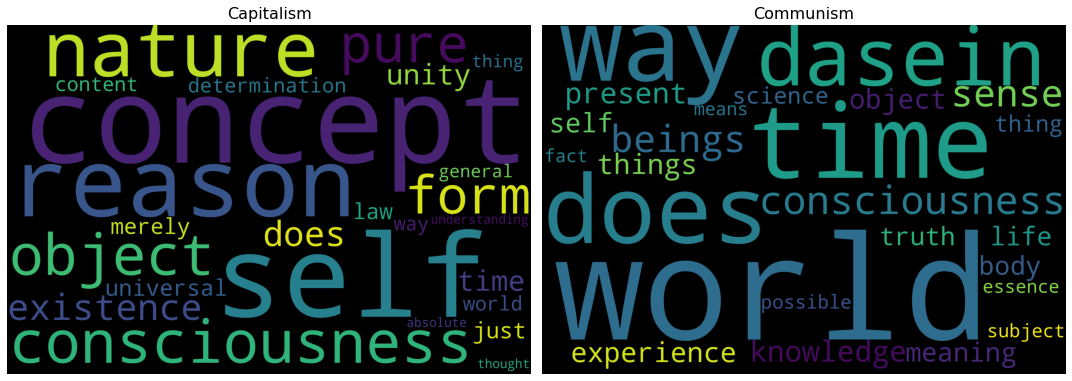

In [149]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15,15), sharex=True, sharey=True)
cloud = WordCloud(stopwords=stop_words,
                  width = 3000, height = 2000, random_state=1,
                  background_color='black',
                  max_words=25,
                  prefer_horizontal=1.0)

w = [cap_word_counts, comm_word_counts]
titles = ["Capitalism", "Communism"]
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    cloud.generate_from_frequencies(w[i])
    cloud.to_file(os.path.join("..","figs",titles[i]+".png"))
    plt.gca().imshow(cloud)
    plt.gca().set_title(titles[i], fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


As previousy mentioned, I am no philosopher and do not have much/any experience in literature reviews of these philosophical texts. From the topic distributions above, I can make a less obvious (at least to me) connection between German Idealism and Phenomenology. The majority of sentences from both of these schools fall under topic 6. Let's take a look at the most frequently used words in both of these schools of philosophy.  

In [89]:
#Get word counts of just german idealism and phenomenology
word_list = count_vectorizer.get_feature_names()
#German Idealism 
germ_index = data_df[data_df["school"]=="german_idealism"].index
germ = count_vec[germ_index,:]
#Phenomenology
pheno_index = data_df[data_df["school"]=="phenomenology"].index
phenom = count_vec[pheno_index,:]

count_list = germ.toarray().sum(axis=0)           
germ_word_counts = dict(zip(word_list,count_list))

count_list = phenom.toarray().sum(axis=0)           
phenom_word_counts = dict(zip(word_list,count_list))

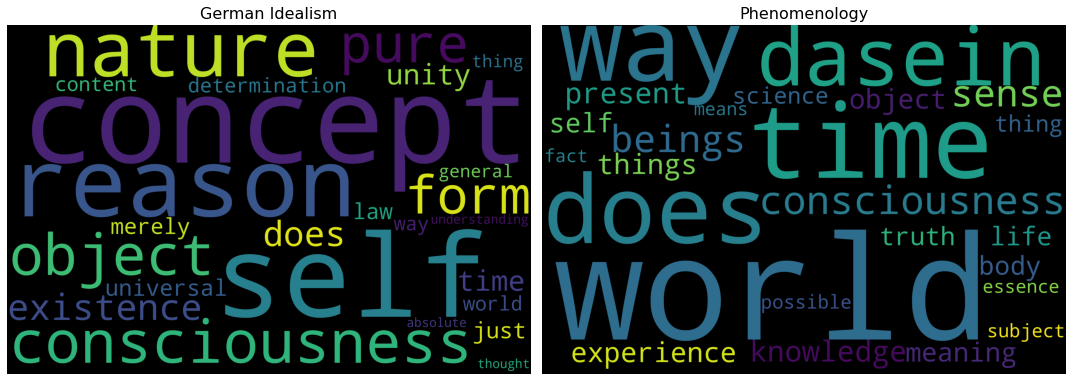

In [150]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15,15), sharex=True, sharey=True)
cloud = WordCloud(stopwords=stop_words,
                  width = 3000, height = 2000, random_state=1,
                  background_color='black',
                  max_words=25,
                  prefer_horizontal=1.0)

w = [cap_word_counts, comm_word_counts]
titles = ["German Idealism", "Phenomenology"]
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    cloud.generate_from_frequencies(w[i])
    cloud.to_file(os.path.join("..","figs",titles[i]+".png"))
    plt.gca().imshow(cloud)
    plt.gca().set_title(titles[i], fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


Again, there are a lot of similarities, including consciousness being/existing. Referring the first visuals of this notebook, Phenomenology has 5 titles from 3 different authors, and German Idealism has 7 titles from also from 3 different authors. One of the books from German Idealism is called "The Phenomenology Of Spirit". Are the two schools of thought similar in topics discussed, or perhaps is there overlap in one specific author's ideas? 

In [119]:
#Group topic counts by author and title for German Idealism and phenomenology
school_subset = topic_proportions[topic_proportions["school"].isin(["german_idealism", "phenomenology"])]
total_sent_counts = school_subset.groupby(["school", "author", "title"], as_index = False)["sentence_str"].count().rename(columns = {"sentence_str": "total_sentences"})

counts_by_topics = school_subset.groupby(["school", "author","title", "dominant_topic"], as_index=False)["sentence_str"].count().rename(columns={"sentence_str":"count"})
topic_6 = counts_by_topics[counts_by_topics["dominant_topic"]==6]

perc_sent_df = pd.merge(topic_6, total_sent_counts, how = "left", on = ["school", "author", "title"])
perc_sent_df["perc"] = perc_sent_df["count"]/perc_sent_df["total_sentences"]


In [132]:
perc_german = perc_sent_df[perc_sent_df["school"] == "german_idealism"]
fig = px.bar(perc_german, x="author", y="perc",title="Proporition of Sentences in Topic 6 - German Idealism", color ="title", barmode = "group",
            category_orders = {"author": [a for a in list(perc_sent_df["author"])],
                              "title": [t for t in list(perc_sent_df["title"])]
                              },
            labels={
                     "title": "Title of Text",
                     "perc": "Percent of Sentences in Topic 6",
                    "author":"Author"
                 })
fig.show()

perc_pheno = perc_sent_df[perc_sent_df["school"] == "phenomenology"]
fig = px.bar(perc_pheno, x="author", y="perc",title="Proporition of Sentences in Topic 6 - Phenomenology", color ="title", barmode = "group",
            category_orders = {"author": [a for a in list(perc_sent_df["author"])],
                              "title": [t for t in list(perc_sent_df["title"])]
                              },
            labels={
                     "title": "Title of Text",
                     "perc": "Percent of Sentences in Topic 6",
                    "author":"Author"
                 })
fig.show()

All of the various texts by each author have over 40% of their sentences dominated by Topic 6. The majority of German Idealism titles (all but one) have over 50% of their sentences in topic 6. Interestingly, the titles from the Phenomenology author Husserl have 75% and 69% of the sentences dominated by topic 6. Perhaps concepts discussed in his texts significantly overlap with the ideas presented in German idealism. 

While Husserl's texts have a higher proportion of sentences that can be attributed to topic 6, the other two phenomenology authors still have a large proportion of sentences that overlap with the topic, so I still think it can be concluded the there is an overlap in content and concepts discussed between German Idealism and Phenomenology, with perhaps more similarities between Husserl and the authors that fall into the school of German Idealism.

## 4) Conclusion 

Through the use of Topic Modeling, we were able to identify different concepts and topics that were presented in various philosophical texts from 13 different schools of philosophy, and a total of 36 different authors. Utilizing an implementation fo LDA from sklearn, we were able to identify 8 topics and show the most frequent words from each. Unsuprisingly, common words were things like "consciousness", "existence", "truth", and "self",, all things one can imagine a philosopher conteplates on a day to day basis. We saw four distinct topics in the model visualization, as well as four topics that overlapped in similarity - these topics seem to be general ideas, perhaps making sense that these topics have overlapping content. 

We then dove into topic distributions by school, seeing unsurprisingly that Capitalism and Communism significantly overlap in topic 1, which focuses on economic concepts and ideas. Perhaps less obvious, at least to me, was the significant overlap in German Idealism (60%) and Phenomenology (49%), having a significant proportion of sentences contributing to topoic 6. Was this due to overlappoing ideas from one author, or one specific text? While it seems like HUsserl from the school of Phenomenology has a higher proportion of his sentences falling under topic 6 compared to his peers, there does seem to still be evidence of an overlap in concepts discussed across both schools of philosophy rather than overlapping topics from a subset of authors or texts.

There are many more comparisons that can be made using the analysis and visuals in this notebook. This notebook is a good example of how data analysis and machine learning techniques can be used to greatly speed up and assist in the literature review of these philosophical texts.

In [3]:
#Functionality to save visuals in HTML export 
import plotly
plotly.offline.init_notebook_mode()